### Dependencies

In [42]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Neural Network Methods (EMNIST)

Utilizing neural network methods and comparing their effectiveness through their test accuracy. No need to utilize ROC curves as the provided classes are balanced, also not requiring the need of class balancing methods. 
<br><br>Three exclusively neural network approaches: 
* Multilayer perceptron (MLP)
* Convolution Neural Network (CNN)
* Visual Transformer (ViT)

## Data Loading (No Augmentation)

For the sake of computation power and time we are utilizing the letters split of the EMNIST dataset which is a subset containing only 26 classes. This combines both uppercase and lowercase into a single class, and has the additional benefit of having equal counts across all classes.

In [4]:
def load_dataset(download_dir, download_needed, batch_size, t):
    train_set = torchvision.datasets.EMNIST(
        root=download_dir,
        split="letters",
        train=True,
        download=download_needed,
        transform=transforms.Compose(t)
    )

    train_loader = DataLoader(
        train_set, 
        batch_size=batch_size, 
        shuffle=True,
        pin_memory=True
    )

    test_set = torchvision.datasets.EMNIST(
        root=download_dir,
        split="letters",
        train=False,
        download=download_needed,
        transform=transforms.Compose(t)
    )

    test_loader = DataLoader(
        test_set,
        batch_size=batch_size,
        shuffle=False,
        pin_memory=True
    )

    return train_loader, train_set, test_loader, test_set

download_dir = "./downloads"
batch_size = 1024

train_loader, train_set, test_loader, test_set = load_dataset(download_dir, True, batch_size, [transforms.ToTensor()])


In [ ]:
print("Training Examples: ", len(train_set))
print("Testing Examples: ", len(test_set))

Training Examples:  124800
Testing Examples:  20800


## Multilayer Perceptron (MLP)
We will be training an MLP model on the EMNIST dataset while changing the hyperparameters to see which best suites the task at hand. We will be tuning the number of hidden layers and the dimension of the hidden layers, and training each combination on 15 epochs for the sake of time and efficiency.

In [6]:
class MLP(nn.Module):

    # Initialize network with hidden_layers + 2 (input and output l layers)
    def __init__(self, input_dim, hidden_dim, hidden_layers):
        super().__init__()

        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_dim, hidden_dim))
        self.layers.append(nn.ReLU())
        self.dropout = nn.Dropout(p=0.4)

        for _ in range(hidden_layers):
            self.layers.append(torch.nn.Linear(hidden_dim, hidden_dim))
            self.layers.append(nn.ReLU())
            self.layers.append(self.dropout)

        self.layers.append(nn.Linear(hidden_dim, 26))

    # Define forward pass to output logits and loss if provided
    def forward(self, vals: torch.Tensor, targets: torch.Tensor = None):
        for layer in self.layers:
            vals = layer(vals)

        if targets != None:
            loss = F.cross_entropy(vals, targets)
        else:
            loss = None

        return vals, loss
    
    
    def __str__(self):
        retString = f"MLP Model with {len(self.layers) + 2} Layers\n\n"

        for i, layer in enumerate(self.layers):
            retString += f"({i}) " + layer.__str__() + "\n"

        return retString
    
def test_accuracy(model, data_loader, input_dim=28*28, cnn=False):
    model.eval()
    correct_predictions = 0

    for data, labels in data_loader:
        data = data.to(device)
        labels = labels.to(device)
        labels = labels - 1

        if not cnn:
            data = data.view(-1, input_dim)
        logits, loss = model(data)
        probs = F.softmax(logits, dim=1)
        predicted_class = torch.argmax(probs, dim=1)
        correct_predictions += sum(predicted_class == labels) / len(data)

    return correct_predictions / len(data_loader)

def train_model(model, num_epochs, train_loader, optim, input_dim=28*28, cnn=False):
    model.train()

    loss_arr = []

    for i in range(num_epochs):
        total_loss = 0

        if i == 10:
            optim.param_groups[0]["lr"] = 0.0001

        for _, (data, labels) in tqdm(enumerate(train_loader)):
            data = data.to(device)
            labels = labels.to(device)
            labels = labels - 1

            if not cnn:
                data = data.view(-1, input_dim)

            logits, loss = model(data, labels)

            optim.zero_grad()
            loss.backward()
            optim.step()

            total_loss += loss

        loss_arr.append(total_loss.item() / len(train_loader))
        print(f"Epoch {i + 1}: {total_loss.item() / len(train_loader)}")

    return loss_arr

In [ ]:
input_dim = 28 * 28
num_epochs = 15
learning_rate = 0.001

hidden_dims = [int(28 * 28 * 0.5), 28 * 28, 28 * 28 * 2]
hidden_layers = [10, 15, 20]
layer_dim_loss = [] # Will be 3D array with rows being loss of a layer count vs all dims
layer_dim_accuracy = [] # Will be 2D array with rows being test accuracy of a layer count vs all dims

for l in hidden_layers:
    layer_arr_loss = []
    layer_arr_accuracy = []

    for d in hidden_dims:
        model = MLP(input_dim, d, l)
        model.to(device)
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        loss_arr = train_model(model, num_epochs, train_loader, optimizer, input_dim)
        layer_arr_loss.append(loss_arr)

        with torch.no_grad():
            layer_arr_accuracy.append(test_accuracy(model, test_loader, input_dim).item())

    layer_dim_loss.append(layer_arr_loss)
    layer_dim_accuracy.append(layer_arr_accuracy)

In [51]:
layer_dim_loss[1][0]

[2.9681539066502305,
 2.252814371077741,
 2.144628055760118,
 1.9396681238393314,
 1.730256627817623,
 1.5469754328493213,
 1.4155155869780993,
 1.3708519857437884,
 1.3183957709640752,
 1.3206554475377819,
 1.2677233336401768,
 1.1879839037285476,
 1.1473003449987194,
 1.1206411142818262,
 1.101255072922003]

### Plotting Loss over Hyperparameter Tuning

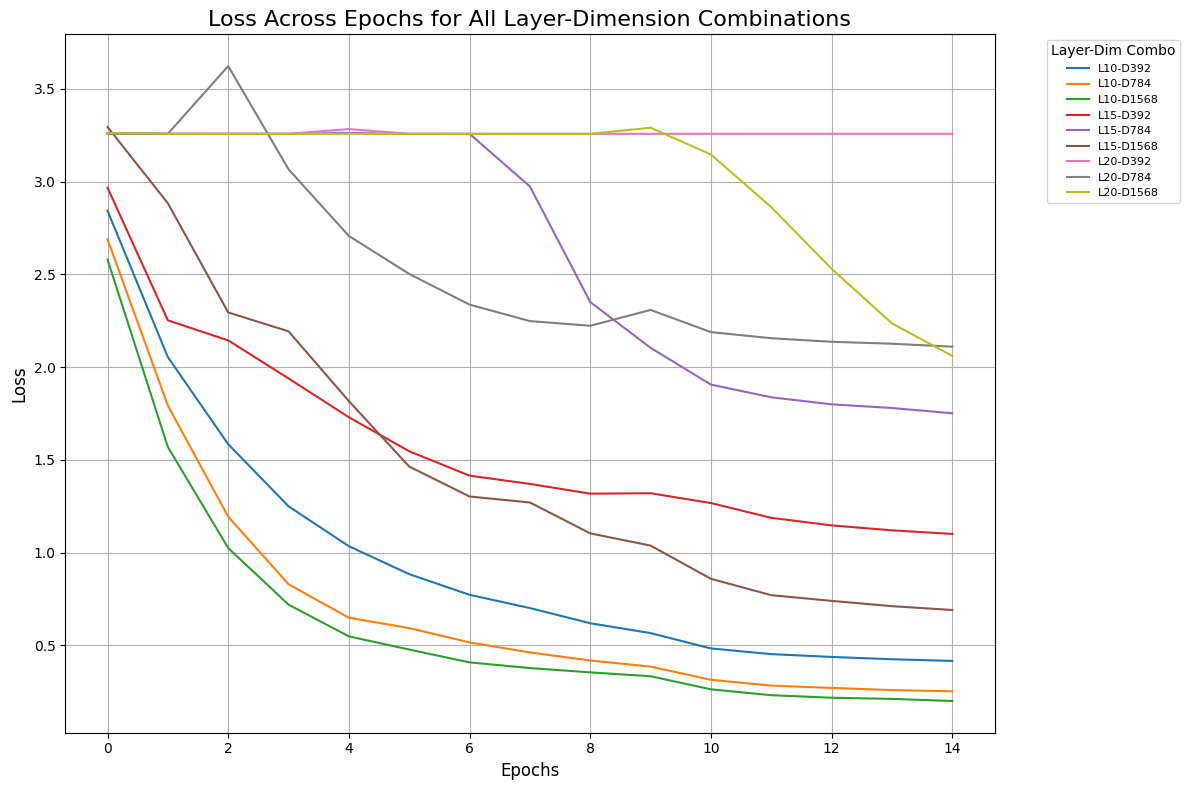

In [ ]:
plt.figure(figsize=(12, 8))
hidden_dims = [int(28 * 28 * 0.5), 28 * 28, 28 * 28 * 2]

for i, layer in enumerate(hidden_layers):
    for j, dim in enumerate(hidden_dims):
        plt.plot(range(len(layer_dim_loss[i][j])), layer_dim_loss[i][j], label=f"L{layer}-D{dim}")

plt.title("Loss Across Epochs for All Layer-Dimension Combinations", fontsize=16)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.legend(title="Layer-Dim Combo", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.show()

### Finding Best Model Based on Testing Accuracy

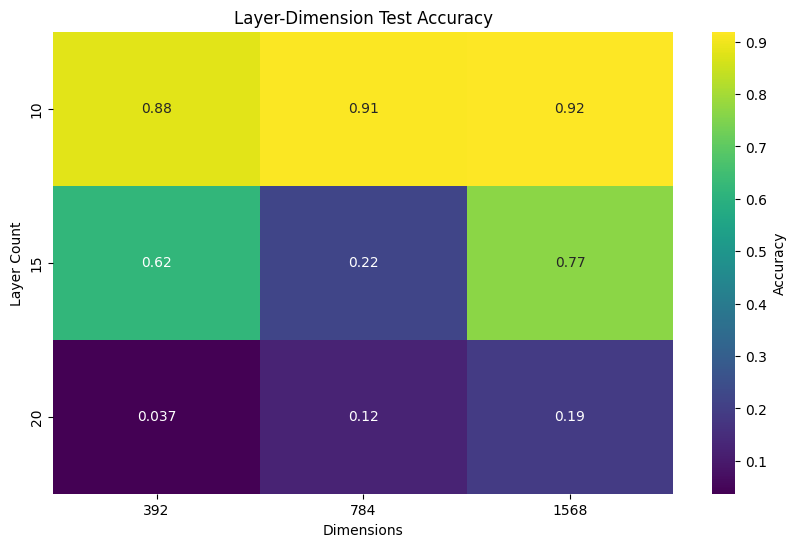

In [45]:
plt.figure(figsize=(10, 6))
sns.heatmap(layer_dim_accuracy, annot=True, cmap="viridis", cbar_kws={'label': 'Accuracy'}, xticklabels=hidden_dims, yticklabels=hidden_layers)
plt.title("Layer-Dimension Test Accuracy")
plt.xlabel("Dimensions")
plt.ylabel("Layer Count")
plt.show()

Training bigger networks is more difficult and requires the utilization of training tricks to make gradients propogate smoothly. So when using more and more layers we see a decrease in performance while increasing the hidden dimensions gives us an increase in performance over a specific layer count.

In [27]:
class CNN(nn.Module):
    def __init__(self, hidden_dim1, hidden_dim2, dropout):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(1, hidden_dim1, kernel_size=(4, 4), padding=(1, 1), stride = (1, 1)),
            nn.BatchNorm2d(hidden_dim1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(1, 1)),
            nn.Conv2d(hidden_dim1, hidden_dim2, kernel_size=(4, 4), padding=(1, 1), stride = (1, 1)),
            nn.BatchNorm2d(hidden_dim2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(1, 1)),
            nn.Conv2d(hidden_dim2, hidden_dim2, kernel_size=(4, 4), padding=(1, 1), stride = (1, 1)),
            nn.BatchNorm2d(hidden_dim2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),
        )

        self.classifier = nn.Sequential(
            nn.Linear(11 * 11 * hidden_dim2, 1024),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(1024, 26)
        )

    def forward(self, vals: torch.Tensor, targets: torch.Tensor = None):
        logits = self.classifier(self.features(vals).view(vals.shape[0], -1))

        if targets != None:
            loss = F.cross_entropy(logits, targets)
        else:
            loss = None

        return logits, loss

In [ ]:
learning_rate = 0.001

hidden_dims = [(16, 32), (32, 64), (48, 96)]
epoch_counts = [10, 15, 20]
epoch_dim_loss = [] # Will be 3D array with rows being loss of a layer count vs all dims
epoch_dim_accuracy = [] # Will be 2D array with rows being test accuracy of a layer count vs all dims

for e in epoch_counts:
    epoch_loss = []
    epoch_accuracy = []

    for dim1, dim2 in hidden_dims:
        model = CNN(dim1, dim2, 0.4)
        model.to(device)
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        loss_arr = train_model(model, e, train_loader, optimizer, cnn=True)
        epoch_loss.append(loss_arr)

        with torch.no_grad():
            epoch_accuracy.append(test_accuracy(model, test_loader, cnn=True).item())

    epoch_dim_loss.append(epoch_loss)
    epoch_dim_accuracy.append(epoch_accuracy)

### Finding Best Model Based on Testing Accuracy

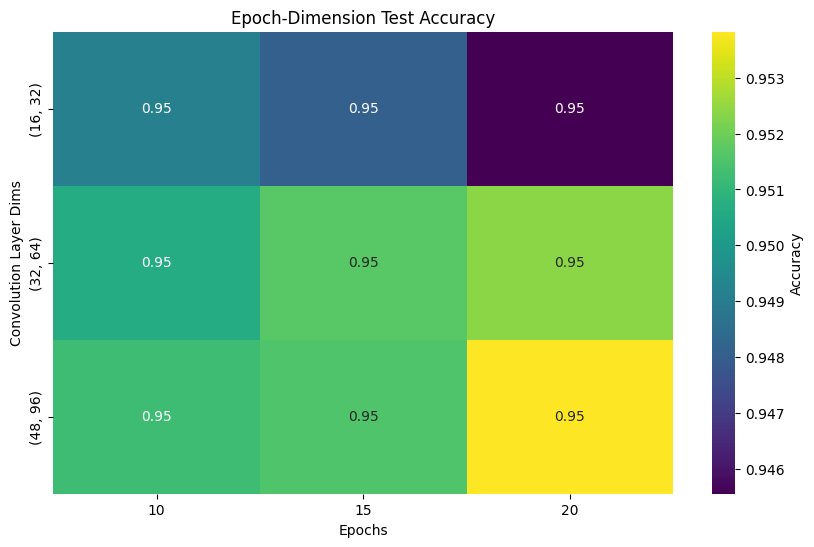

In [57]:
hidden_dims = [(16, 32), (32, 64), (48, 96)]

plt.figure(figsize=(10, 6))
sns.heatmap(epoch_dim_accuracy, annot=True, cmap="viridis", cbar_kws={'label': 'Accuracy'}, xticklabels=epoch_counts, yticklabels=hidden_dims)
plt.title("Epoch-Dimension Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Convolution Layer Dims")
plt.show()

Decided to not use visual transformer (ViT) as it thrives under more data and a larger pretraining set while we only have over 100k observations to train the model with. This can be explored in the future but for our purposes we did not test this method.